# 0.0. Imports 

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.display import Image
from geopy.geocoders import Nominatim

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import dummy
from sklearn import metrics
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model

## 0.1. Helper Functions

In [75]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Data

In [76]:
df_raw = pd.read_csv( '../data/raw/churn.csv' )

# 1.0. Data Description

In [77]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [78]:
df1.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card','is_active_member', 'estimated_salary', 'exited']

## 1.2. Data Dimensions

In [79]:
df1.shape

(10000, 14)

## 1.3. Check NA

In [80]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.4. Data Dtypes

In [81]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5. Descriptive Statistics 

 ## **Features**

* **NowNumber:** O número da coluna
* **CustomerID:** Identificador único do cliente
* **Surname:** Sobrenome do cliente.
* **CreditScore:** A pontuação de Crédito do cliente para o mercado de consumo.
* **Geography:** O país onde o cliente reside.
* **Gender:** O gênero do cliente.
* **Age:** A idade do cliente.
* **Tenure:** Número de anos que o cliente permaneceu ativo.
* **Balance:** Valor monetário que o cliente tem em sua conta bancária.
* **NumOfProducts:** O número de produtos comprado pelo cliente no banco.
* **HasCrCard:** Indica se o cliente possui ou não cartão de crédito.
* **IsActiveMember:** Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
* **EstimateSalary:** Estimativa do salário mensal do cliente.
* **Exited:** Indica se o cliente está ou não em Churn.

In [82]:
num_attr = df1.select_dtypes( include=['int64', 'float64'] )
cat_attr = df1.select_dtypes( include=['object'] )

### 1.5.1. Numerical Attributes

In [83]:
# tendency central: mean, median
ct1 = pd.DataFrame( num_attr.apply(np.mean) )
ct2 = pd.DataFrame( num_attr.apply(np.median) )

# dispersion: min,  max, range, std
d1 = pd.DataFrame( num_attr.apply(np.min) )
d2 = pd.DataFrame( num_attr.apply(np.max) )
d3 = pd.DataFrame( num_attr.apply(lambda x: np.max(x) - np.min(x)) )
d4 = pd.DataFrame( num_attr.apply(lambda x: x.std()) )

# shape: skew, kurtosis
s1 = pd.DataFrame( num_attr.apply(lambda x: x.skew()) )
s2 = pd.DataFrame( num_attr.apply(lambda x: x.kurtosis()) )

m1 = pd.concat([d1, d2, d3 ,ct1, ct2, d4, s1, s2], axis=1).reset_index()
m1.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.0000,10000.0000,9999.0000,5000.5000,5000.5000,2886.8957,0.0000,-1.2000
1,customer_id,15565701.0000,15815690.0000,249989.0000,15690940.5694,15690738.0000,71936.1861,0.0011,-1.1961
2,credit_score,350.0000,850.0000,500.0000,650.5288,652.0000,96.6533,-0.0716,-0.4257
3,age,18.0000,92.0000,74.0000,38.9218,37.0000,10.4878,1.0113,1.3953
4,tenure,0.0000,10.0000,10.0000,5.0128,5.0000,2.8922,0.0110,-1.1652
5,balance,0.0000,250898.0900,250898.0900,76485.8893,97198.5400,62397.4052,-0.1411,-1.4894
6,num_of_products,1.0000,4.0000,3.0000,1.5302,1.0000,0.5817,0.7456,0.5830
7,has_cr_card,0.0000,1.0000,1.0000,0.7055,1.0000,0.4558,-0.9018,-1.1870
8,is_active_member,0.0000,1.0000,1.0000,0.5151,1.0000,0.4998,-0.0604,-1.9967
9,estimated_salary,11.5800,199992.4800,199980.9000,100090.2399,100193.9150,57510.4928,0.0021,-1.1815


 ## num_of_products

In [84]:
df1['num_of_products'].value_counts(normalize=True)

1   0.5084
2   0.4590
3   0.0266
4   0.0060
Name: num_of_products, dtype: float64

 ## has_cr_card

In [85]:
df1['has_cr_card'].value_counts(normalize=True)

1   0.7055
0   0.2945
Name: has_cr_card, dtype: float64

 ## is_active_member

In [86]:
df1['is_active_member'].value_counts(normalize=True)

1   0.5151
0   0.4849
Name: is_active_member, dtype: float64

 ## exited

In [87]:
df1['exited'].value_counts(normalize=True)

0   0.7963
1   0.2037
Name: exited, dtype: float64

### 1.5.2. Categorical Attributes

In [88]:
cat_attr.describe().T

,count,unique,top,freq
surname,10000,2932,Smith,32
geography,10000,3,France,5014
gender,10000,2,Male,5457


 ## geography

In [89]:
df1['geography'].value_counts(normalize=True)

France    0.5014
Germany   0.2509
Spain     0.2477
Name: geography, dtype: float64

 ## gender

In [90]:
df1['gender'].value_counts(normalize=True)

Male     0.5457
Female   0.4543
Name: gender, dtype: float64

# 2.0. Feature Engineering

In [91]:
df2 = df1.copy()

## 2.1. Mapa Mental de hipóteses

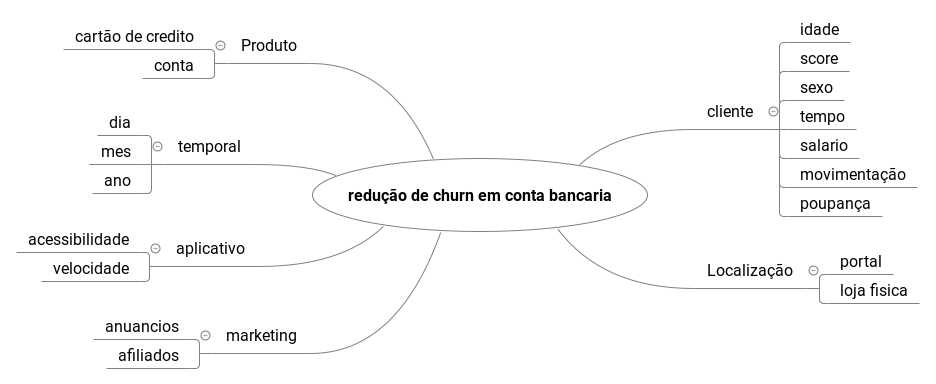

In [92]:
Image('../images/mindmap-churn.png')

## 2.2. Criação de Hipóteses

 ## **Cliente**

1. Clientes entre 40 a 60 anos, têm menos chance de abandonar o serviço comparado ao resto da baixo.
2. Cliente com score card abaixo de 400 tem mais chances de abandonar o serviço.
3. Clientes do sexo feminino tem 60% de manter o serviço.
4. Cliente acima de 5 anos usando o  serviço tem 80% de chance de manter o serviço.
5. Clientes que têm salário acima da média, têm mais chances de abandonar o serviço.
6. Clientes que fazem 10 movimentações ao mês, têm mais chances de manter o serviço.
7. Clientes que não têm dinheiro na poupança têm mais chances de abandonar o serviço.

## **Localização**
1. Clientes residentes na residentes na Espanha tem mais chances de manter o serviço em comparação comparado aos outros países
2. Clientes que acessam mais o portal têm mais chances de abandonar o serviço.


## **Marketing**
1. Clientes provenientes de de afiliados, têm mais chances de manter o serviço.
2. Anúncios de marketing são responsáveis pela maior quantidade de novos clientes, e não são mais fiéis à empresa do que por outros meios.

## **Produtos**
1. Clientes que possuem cartão de crédito, tem mais chances de manter o serviço dos que não tem.


## 2.3. Priorização de Hipóteses

* **h1.** Clientes entre 40 a 60 anos, têm menos chance de abandonar o serviço comparado ao resto da baixo.
* **h2.** Cliente com score card abaixo de 400 tem mais chances de abandonar o serviço.
* **h3.** Clientes do sexo feminino tem 60% de manter o serviço.
* **h4.** Cliente acima de 5 anos usando o  serviço tem 80% de chance de manter o serviço.
* **h5.** Clientes que têm salário acima da média, têm mais chances de abandonar o serviço.
* **h6.** Clientes que não têm dinheiro na poupança têm mais chances de abandonar o serviço.
* **h7.** Clientes residentes na residentes na Espanha tem mais chances de manter o serviço em comparação comparado aos outros países
* **h8.** Clientes que possuem cartão de crédito, tem mais chances de manter o serviço dos que não tem.


## 2.4. Create Feature

In [93]:
df2.loc[ df2['geography'] == 'France', 'country_lat'] = float(geolocator.geocode('France').raw['lat'])
df2.loc[ df2['geography'] == 'Germany', 'country_lat'] = float(geolocator.geocode('Germany').raw['lat'])
df2.loc[ df2['geography'] == 'Spain', 'country_lat'] = float(geolocator.geocode('Spain').raw['lat'])

df2.loc[ df2['geography'] == 'France', 'country_lon'] = float(geolocator.geocode('France').raw['lon'])
df2.loc[ df2['geography'] == 'Germany', 'country_lon'] = float(geolocator.geocode('Germany').raw['lon'])
df2.loc[ df2['geography'] == 'Spain', 'country_lon'] = float(geolocator.geocode('Spain').raw['lon'])

# 3.0. Data Filtering

In [94]:
df3 = df2.copy()

In [95]:
drop_cols = ['row_number', 'customer_id', 'surname']
df3 = df3.drop(drop_cols, axis=1)

# 4.0. EDA

In [96]:
df4 = df3.copy()

# 5.0. Data Preprocessing

In [97]:
df5 = df4.copy()

In [98]:
le = pp.LabelEncoder()

df5['geography'] = le.fit_transform( df5[['geography']].values.ravel() )
df5['gender'] = le.fit_transform( df5[['gender']].values.ravel() )

# 6.0. Feature Selection

In [99]:
df6 = df5.copy()

# 7.0. Model Traning

In [100]:
X = df6.drop('exited', axis=1)
y = df6['exited'].values

In [101]:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     train_size=0.8, 
                                                     random_state=42, 
                                                     shuffle=True, 
                                                     stratify=None)

## 7.1. DummyClassifier

In [102]:
# model definition
model_baseline = dummy.DummyClassifier(strategy='prior', random_state=42, constant=None)

# model fit
model_baseline.fit( X_train, y_train )

# model predict
yhat_baseline = model_baseline.predict( X_val )

# model performance
print(metrics.classification_report( y_val, yhat_baseline,
                                    labels=None, 
                                    target_names=None, 
                                    sample_weight=None, 
                                    digits=2, 
                                    output_dict=False, 
                                    zero_division=0))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1607
           1       0.00      0.00      0.00       393

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000



## 7.2. KNeighborsClassifier

In [103]:
# # model definition
model_knn = neighbors.KNeighborsClassifier(n_neighbors=5, 
                                           weights='uniform', 
                                           algorithm='auto', 
                                           leaf_size=30, 
                                           p=2, 
                                           metric='minkowski', 
                                           metric_params=None, 
                                           n_jobs=None)

# model fit
model_knn.fit( X_train, y_train )

# model predict
yhat_knn = model_knn.predict( X_val )

# model performance
print(metrics.classification_report( y_val, yhat_knn,
                                    labels=None, 
                                    target_names=None, 
                                    sample_weight=None, 
                                    digits=2, 
                                    output_dict=False, 
                                    zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1607
           1       0.24      0.09      0.14       393

    accuracy                           0.76      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.70      0.76      0.72      2000



## 7.3 SVM

In [104]:
# model definition
model_svm = svm.SVC(C=1.0, 
                    kernel='rbf', 
                    degree=3, 
                    gamma='scale', 
                    coef0=0.0, 
                    shrinking=True, 
                    probability=False, 
                    tol=0.001, 
                    cache_size=200, 
                    class_weight=None, 
                    verbose=False, 
                    max_iter=-1, 
                    decision_function_shape='ovr', 
                    break_ties=False, 
                    random_state=42)
# model fit
model_svm.fit( X_train, y_train )

# model predict
yhat_svm = model_svm.predict( X_val )

# model performance
print(metrics.classification_report( y_val, yhat_svm,
                                    labels=None, 
                                    target_names=None, 
                                    sample_weight=None, 
                                    digits=2, 
                                    output_dict=False, 
                                    zero_division=0))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1607
           1       0.00      0.00      0.00       393

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000



## 7.4. RandomForestClassifier

In [105]:
# model definition
model_rf = ensemble.RandomForestClassifier(n_estimators=100, 
                                           criterion='gini', 
                                           max_depth=None, 
                                           min_samples_split=2, 
                                           min_samples_leaf=1, 
                                           min_weight_fraction_leaf=0.0, 
                                           max_features='auto', 
                                           max_leaf_nodes=None, 
                                           min_impurity_decrease=0.0, 
                                           min_impurity_split=None, 
                                           bootstrap=True, 
                                           oob_score=False, 
                                           n_jobs=None, 
                                           random_state=42, 
                                           verbose=0, 
                                           warm_start=False, 
                                           class_weight=None, 
                                           ccp_alpha=0.0, 
                                           max_samples=None)
# model fit
model_rf.fit( X_train, y_train )

# model predict
yhat_rf = model_rf.predict( X_val )

# model performance
print(metrics.classification_report( y_val, yhat_rf,
                                    labels=None, 
                                    target_names=None, 
                                    sample_weight=None, 
                                    digits=2, 
                                    output_dict=False, 
                                    zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



## 7.5. LogisticRegression

In [106]:
# model definition
model_lr = linear_model.LogisticRegression(penalty='l2', 
                                           dual=False, 
                                           tol=0.0001, 
                                           C=1.0, 
                                           fit_intercept=True, 
                                           intercept_scaling=1, 
                                           class_weight=None, 
                                           random_state=42, 
                                           solver='lbfgs', 
                                           max_iter=100, 
                                           multi_class='auto', 
                                           verbose=0, 
                                           warm_start=False, 
                                           n_jobs=None, 
                                           l1_ratio=None)
# model fit
model_lr.fit( X_train, y_train )

# model predict
yhat_lr = model_lr.predict( X_val )

# model performance
print(metrics.classification_report( y_val, yhat_lr,
                                    labels=None, 
                                    target_names=None, 
                                    sample_weight=None, 
                                    digits=2, 
                                    output_dict=False, 
                                    zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1607
           1       0.42      0.07      0.13       393

    accuracy                           0.80      2000
   macro avg       0.62      0.52      0.51      2000
weighted avg       0.73      0.80      0.74      2000



# 8.0. Hyperparameter Fine-Tuning

# 9.0. Model Perfomance

# 10.0. Deploy to Production